# Variant Watcher V1

In [ ]:
!pip install requests
!pip install pandas
!pip install tabulate
from IPython.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [ ]:
import requests
import pandas as pd
from tabulate import tabulate
from utilities_cust import defang_domain

# Add desired URLS for API calls here, currently logic will only support urlhaus (wip)

In [ ]:
urlhaus = "https://urlhaus.abuse.ch/downloads/csv_online/"

# Downloading the content, in URLHAUS case, it'll come in CSV formatted but seemingly as a text file hence the below handling, comments kept for breakdown

In [ ]:
# DownloAd the text content
req = requests.get(urlhaus)
# Assuming the content is text data (will be for urlhaus, it is still csv 'formatted')
content = req.text
# Def filename to convert our ingested data into a file for handling / manipulation
raw_pulled_data = "raw_pulled_data.txt"
# Write the content to a file
with open(raw_pulled_data, "w", encoding="utf-8") as text_file:
    text_file.write(content)

# Very botched way of dealing with the pulled data, as it'll come in with a header, have placed a static value inside the skip variable to essentially step over until we reach the csv headers. Below is an example

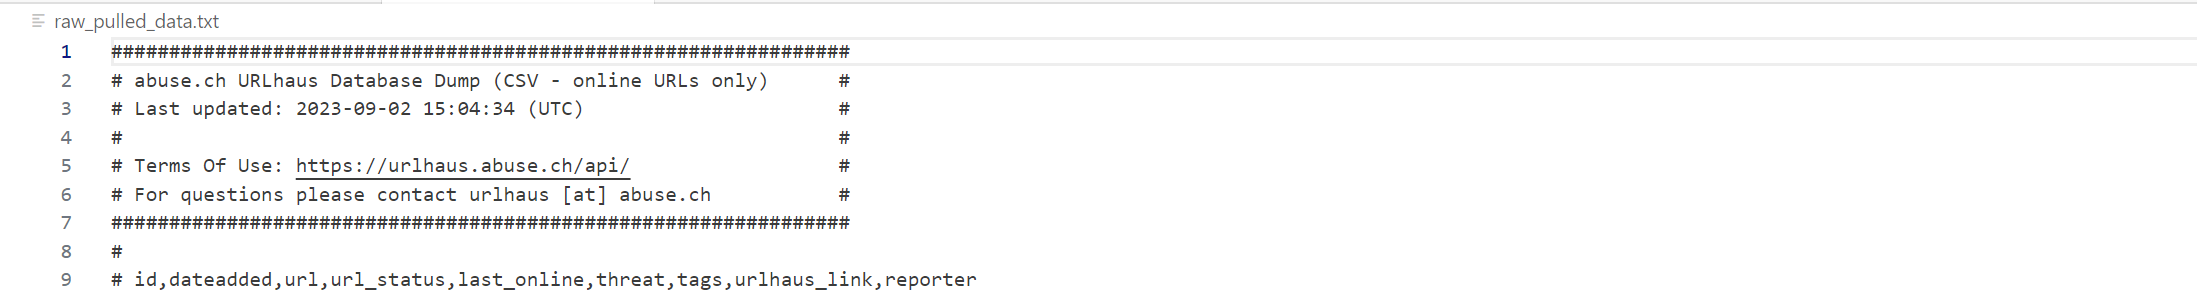

In [ ]:
skip = 16
# Open the file and skip the first 'skip' lines (Due to the header provided, definitely an easier way to do, will look into it)
with open(raw_pulled_data, 'r', encoding='utf-8') as file:
    for _ in range(skip):
        next(file)  # Skip the line

    # Read the remaining content into a new file
    temp_file_path = 'temp_content.txt'
    with open(temp_file_path, 'w', encoding='utf-8') as temp_file:
        temp_file.writelines(file)

# Strips columns we're interested in

In [ ]:
try:
    df = pd.read_csv(temp_file_path, usecols=['url', 'tags', 'threat'])
    # Drop rows with missing tags (yeet errors)
    df = df.dropna(subset=['tags']) 
except ValueError:
    #function this
    skip = 111 
    # Open the file and skip the first 'skip' lines (Due to the header provided, definitely an easier way to do, will look into it)
    with open(raw_pulled_data, 'r', encoding='utf-8') as file:
        for _ in range(skip):
            next(file)  # Skip the line

        # Read the remaining content into a new file
        temp_file_path = 'temp_content.txt'
        with open(temp_file_path, 'w', encoding='utf-8') as temp_file:
            temp_file.writelines(file) 
    df = pd.read_csv(temp_file_path, usecols=['url', 'tags', 'threat'])
    # Drop rows with missing tags (yeet errors)
    df = df.dropna(subset=['tags']) 

# Below is the way I dealt with allowing choice, the case sensitivty is an issue that I'll look at handling a lot better, however having the dataset visible is a good thing in itself so may keep it

In [ ]:
# Split the 'tags' column by commas to handle comma-separated tags
df['tags'] = df['tags'].str.split(',')
# Flatten the list of tags into separate rows
df = df.explode('tags')
# Grab unique values
unique_tags = df['tags'].unique() 

# Printing out all unique tags (variants found in the dataset)

In [ ]:
# Int to manage output
line_cleaner = 0
# Loop through and remove duplicates from df[df]['tags']
print("All variants by tag in the dataset:")
tag_list = []
row = []

for tag in unique_tags:
    uniq_rdf = df[df['tags'] == tag]
    row.append(tag)

    if len(row) == 4:
        tag_list.append(row)
        row = []
if row:
    tag_list.append(row)

headers = ["Tags 1", "Tags 2", "Tags 3", "Tags 4"]
table_format = "grid" 

print(tabulate(tag_list, headers=headers, tablefmt=table_format))

# Variant Picker

In [ ]:
variant = input("\nWhat variant would you like to gather information from? (Case Sensitive!): ")

# All URLs found associated with your selected Variant

In [ ]:
rdf = df[df['tags'].str.contains(variant)]
# Convert the data to an HTML table
rdf_html = rdf.to_html()
# Display the HTML table as raw HTML (non-clickable)
HTML(rdf_html)

In [ ]:
variant_url_dict = {}
variant_url_dict[variant] = rdf['url'].tolist()

variant_url_list = variant_url_dict[variant]

# Split the URLs to extract domains
domains = [url.split('/')[2] for url in variant_url_list]
defanged_domains = [defang_domain(domain) for domain in domains]
# Create a dataframe to count the occurrences of each domain
domain_counts_df = pd.DataFrame({'domain': defanged_domains})

# Count the occurrences of each domain
domain_counts = domain_counts_df['domain'].value_counts()
# Display the top 20 domains by count
top_20_domains = domain_counts.head(20)

# Create a datafraame from the top 20 domains Series
top_20_domains_df = pd.DataFrame({'domain': top_20_domains.index, 'count': top_20_domains.values})

# Convert the DataFrame to an HTML table (already defanged, but just looked a lot nicer)
top20_html = top_20_domains_df.to_html()

HTML(top20_html)